In [2]:
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    # %pip install snntorch
    FILEPATH = '/content/drive/MyDrive'
except:
    FILEPATH = '/Users/tyler/Documents/University/YEAR3/PROJECT - COMP30040/Datasets/SmallDataset'

In [3]:
import snntorch as snn
import pandas as pd
import spectrograms
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from typing import Union, Tuple
from numba import njit, guvectorize

CSV = 'sample_ISD.csv'
AUDIO = 'audio compression'
DERIVED_COLUMN = 'category'
SAVE_DIR = 'music_genre'

dataset = pd.read_csv(f'{FILEPATH}/{CSV}', index_col=0)
print(dataset)

               filename              category         source supercategory
0         music-hd-0048  westernart/classical  accompaniment         music
1    music-jamendo-0200         indierock/pop  accompaniment         music
2    music-jamendo-0041  pop/soul/electronica  accompaniment         music
3        music-rfm-0028           electronica  accompaniment         music
4     music-fma-wa-0000  westernart/classical  accompaniment         music
..                  ...                   ...            ...           ...
899      music-fma-0075            hiphop/rap          vocal         music
900  music-jamendo-0023            pop/gospel          vocal         music
901      music-fma-0086                  folk          vocal         music
902  music-jamendo-0080            rap/hiphop          vocal         music
903      music-fma-0022        pop/rock/dance          vocal         music

[904 rows x 4 columns]


# Derive Inputs with constant duration

### Sample Data into X_train, X_test, etc.

### Dataset Form
1. Input Features ($x$) in form $n \times t \times f$
2. Labels ($y$), where $0$ is non-music, and $1$ is music

### Input Types
1. Spectrogram
2. MFCC
3. CQT
4. Mel-Spectrogram

### Sampling Data

In [6]:
mapping = {
    'adventure': 'Folk',
    'blues': 'Blues',
    'blues/electronica': 'Electronic',
    'blues/funk': 'Funk',
    'blues/indierock': 'Rock',
    'blues/jazz/adventure': 'Jazz',
    'blues/pop/folk': 'Pop',
    'blues/rock': 'Rock',
    'blues/rock/country': 'Country',
    'blues/rock/indierock': 'Rock',
    'blues/rock/jazz': 'Jazz',
    'blues/rock/pop': 'Pop',
    'blues/rock/rnb': 'R&B',
    'country': 'Country',
    'country/blues/rock': 'Rock',
    'country/folk': 'Folk',
    'country/pop': 'Pop',
    'country/pop/folk': 'Folk',
    'dance': 'Electronic',
    'electronica': 'Electronic',
    'electronica/dance': 'Electronic',
    'folk': 'Folk',
    'folk/indierock': 'Rock',
    'folk/pop': 'Pop',
    'folk/pop/funk': 'Funk',
    'funk/blues/jazz': 'Jazz',
    'funk/electronica': 'Electronic',
    'funk/rnb/adventure': 'R&B',
    'funk/rnb/electronica': 'Electronic',
    'hiphop': 'Hip Hop',
    'hiphop/rap': 'Hip Hop',
    'indierock/folk/pop': 'Pop',
    'indierock/pop': 'Pop',
    'indierock/rock': 'Rock',
    'jazz': 'Jazz',
    'jazz/adventure': 'Jazz',
    'jazz/blues': 'Jazz',
    'jazz/electronica': 'Electronic',
    'jazz/pop/soul': 'Jazz',
    'latin': 'Jazz',
    'metal/rap': 'Metal',
    'metal/rock': 'Metal',
    'pop': 'Pop',
    'pop/blues': 'Pop',
    'pop/electronica': 'Electronic',
    'pop/electronica/hiphop': 'Hip Hop',
    'pop/experimental': 'Pop',
    'pop/folk': 'Folk',
    'pop/funk/adventure': 'Funk',
    'pop/gospel': 'Pop',
    'pop/hiphop': 'Hip Hop',
    'pop/hiphop/rock': 'Rock',
    'pop/jazz': 'Jazz',
    'pop/jazz/latin': 'Jazz',
    'pop/rap/rock/hiphop': 'Hip Hop',
    'pop/rock': 'Rock',
    'pop/rock/dance': 'Electronic',
    'pop/rock/folk': 'Rock',
    'pop/rock/soul': 'Rock',
    'pop/soul/electronica': 'Electronic',
    'pop/soul/rnb': 'R&B',
    'rap/hiphop': 'Hip Hop',
    'rap/metal': 'Metal',
    'rap/metal/electronica': 'Metal',
    'rap/metal/hiphop': 'Metal',
    'rock': 'Rock',
    'rock/folk': 'Folk',
    'rock/funk/country': 'Country',
    'westernart/baroque': 'Classical',
    'westernart/classical': 'Classical',
    'westernart/romantic': 'Classical',
    'westernart/romantic/classical': 'Classical'
}


X = dataset[dataset['supercategory']=='music']['filename'].tolist()
Y = dataset[dataset['supercategory']=='music']['category'].apply(lambda x: mapping[x])

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

label_mappings = {encoded_label: original_label for original_label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
print(label_mappings)

X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2)

X_train_sample = list(map(lambda file: spectrograms.sample(f"{FILEPATH}/{AUDIO}/{file}.mp3"), X_train))
X_test_sample = list(map(lambda file: spectrograms.sample(f"{FILEPATH}/{AUDIO}/{file}.mp3"), X_test))

{0: 'Blues', 1: 'Classical', 2: 'Country', 3: 'Electronic', 4: 'Folk', 5: 'Funk', 6: 'Hip Hop', 7: 'Jazz', 8: 'Metal', 9: 'Pop', 10: 'R&B', 11: 'Rock'}


### Spectrograms

In [7]:
spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.spectrogram(sample, sr) for sample, sr in X_train_sample]]))
spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.spectrogram(sample, sr) for sample, sr in X_test_sample]]))

spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))

torch.save(spectrogram_train,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/spectrogram_train.pth")
torch.save(spectrogram_test,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/spectrogram_test.pth")

In [8]:
spectrogram_train = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/spectrogram_train.pth")
spectrogram_test = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/spectrogram_test.pth")

### MFCC

In [9]:
mfcc_X_train = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr) for sample, sr in X_train_sample]]))
mfcc_X_test = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr) for sample, sr in X_test_sample]]))

mfcc_train = TensorDataset(mfcc_X_train, torch.LongTensor(y_train))
mfcc_test = TensorDataset(mfcc_X_test, torch.LongTensor(y_test))

torch.save(mfcc_train,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/mfcc_train.pth")
torch.save(mfcc_test,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/mfcc_test.pth")

In [10]:
mfcc_train = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/mfcc_train.pth")
mfcc_test = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/mfcc_test.pth")
print(mfcc_train[0][0].shape)

torch.Size([431, 20])


### CQT

In [11]:
cqt_X_train = Tensor(np.array([x for x, _ in [spectrograms.cqt_spectrogram(sample, sr) for sample, sr in X_train_sample]]))
cqt_X_test = Tensor(np.array([x for x, _ in [spectrograms.cqt_spectrogram(sample, sr) for sample, sr in X_test_sample]]))

cqt_train = TensorDataset(cqt_X_train, torch.LongTensor(y_train))
cqt_test = TensorDataset(cqt_X_test, torch.LongTensor(y_test))

torch.save(cqt_train,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/cqt_train.pth")
torch.save(cqt_test,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/cqt_test.pth")

In [12]:
cqt_train = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/cqt_train.pth")
cqt_test = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/cqt_test.pth")

### Mel Spectrogram

In [13]:
mel_X_train = Tensor(np.array([x for x, _ in [spectrograms.mel_spectrogram(sample, sr) for sample, sr in X_train_sample]]))
mel_X_test = Tensor(np.array([x for x, _ in [spectrograms.mel_spectrogram(sample, sr) for sample, sr in X_test_sample]]))

mel_train = TensorDataset(mel_X_train, torch.LongTensor(y_train))
mel_test = TensorDataset(mel_X_test, torch.LongTensor(y_test))

torch.save(mel_train,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/mel_train.pth")
torch.save(mel_test,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/mel_test.pth")

In [14]:
mel_train = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/mel_train.pth")
mel_test = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_encoding/mel_test.pth")

# Graphing
1. Graphing Threshold and Accuracy
2. Graphing Spikes
3. Graphing a single frequency bin (with/without spikes)

### 1. Graphing Threshold and Accuracy

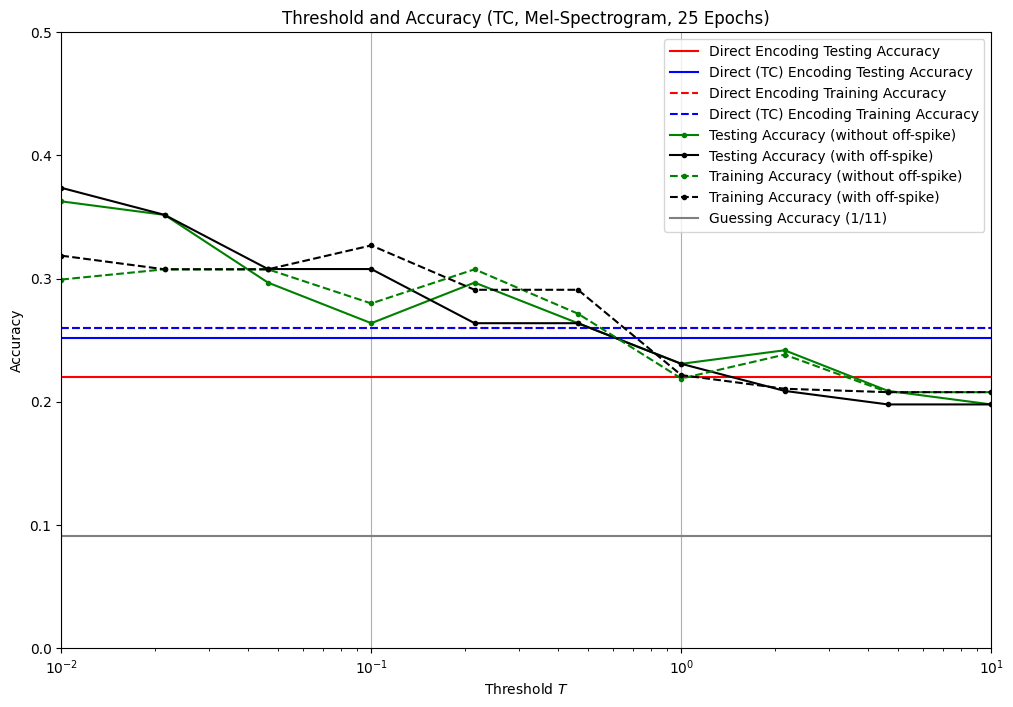

In [105]:
import json
import matplotlib.pyplot as plt

# Specify the path to your JSON file

accuracies = []
percentiles = []
OFFaccuracies = []
OFFpercentiles = []

"""
# Read data from the JSON file
for file in ['Results/TC-Threshold-Music_Source/test.json', 'Results/TC-Threshold-Music_Source/train.json']:
    with open(file, 'r') as json_file:
        data = json.load(json_file)
        percentiles.append([float(percent) for percent in data.keys()])
        accuracies.append(list(data.values()))

for file in ['Results/TC-Threshold-Music_Source/test_off_spike.json', 'Results/TC-Threshold-Music_Source/train_off_spike.json']:
    with open(file, 'r') as json_file:
        data = json.load(json_file)
        OFFpercentiles.append([float(percent) for percent in data.keys()])
        OFFaccuracies.append(list(data.values()))
"""
train_accuracies = {0.01: 0.29916897506925205, 0.021544346900318832: 0.3074792243767313, 0.046415888336127774: 0.3074792243767313, 0.1: 0.27977839335180055, 0.21544346900318834: 0.3074792243767313, 0.46415888336127775: 0.27146814404432135, 1.0: 0.2188365650969529, 2.154434690031882: 0.23822714681440443, 4.6415888336127775: 0.2077562326869806, 10.0: 0.2077562326869806}
test_accuracies = {0.01: 0.3626373626373626, 0.021544346900318832: 0.3516483516483517, 0.046415888336127774: 0.2967032967032967, 0.1: 0.26373626373626374, 0.21544346900318834: 0.2967032967032967, 0.46415888336127775: 0.26373626373626374, 1.0: 0.23076923076923078, 2.154434690031882: 0.24175824175824176, 4.6415888336127775: 0.2087912087912088, 10.0: 0.1978021978021978}

OFFtrain_accuracies = {0.01: 0.3185595567867036, 0.021544346900318832: 0.3074792243767313, 0.046415888336127774: 0.3074792243767313, 0.1: 0.3268698060941828, 0.21544346900318834: 0.29085872576177285, 0.46415888336127775: 0.29085872576177285, 1.0: 0.22160664819944598, 2.154434690031882: 0.21052631578947367, 4.6415888336127775: 0.2077562326869806, 10.0: 0.2077562326869806}
OFFtest_accuracies = {0.01: 0.37362637362637363, 0.021544346900318832: 0.3516483516483517, 0.046415888336127774: 0.3076923076923077, 0.1: 0.3076923076923077, 0.21544346900318834: 0.26373626373626374, 0.46415888336127775: 0.26373626373626374, 1.0: 0.23076923076923078, 2.154434690031882: 0.2087912087912088, 4.6415888336127775: 0.1978021978021978, 10.0: 0.1978021978021978}


for dictionary in [train_accuracies, test_accuracies]:
    percentiles.append([float(percent) for percent in dictionary.keys()])
    accuracies.append(list(dictionary.values()))

for dictionary in [OFFtrain_accuracies, OFFtest_accuracies]:
    OFFpercentiles.append([float(percent) for percent in dictionary.keys()])
    OFFaccuracies.append(list(dictionary.values()))

percentiles = np.array(percentiles).T
accuracies = np.array(accuracies).T
OFFaccuracies = np.array(OFFaccuracies).T
OFFpercentiles = np.array(OFFpercentiles).T

# Plot the data
plt.figure(figsize=(12, 8))

colours = ['red', 'blue', 'red', 'blue', 'green', 'black', 'green', 'black', 'gray']
plt.gca().set_prop_cycle('color', colours)


max_len = 10

plt.plot(OFFpercentiles, np.array([[0.220]*max_len, [0.252]*max_len]).T, linestyle='-', label=['Direct Encoding Testing Accuracy', 'Direct (TC) Encoding Testing Accuracy'])
plt.plot(OFFpercentiles, np.array([[0.260]*max_len, [0.260]*max_len]).T, linestyle='--', label=['Direct Encoding Training Accuracy', 'Direct (TC) Encoding Training Accuracy'])

plt.plot(percentiles[:,1], accuracies[:,1], marker='.', linestyle='-', label='Testing Accuracy (without off-spike)')
plt.plot(OFFpercentiles[:,1], OFFaccuracies[:,1], marker='.', linestyle='-', label='Testing Accuracy (with off-spike)')
plt.plot(percentiles[:,0], accuracies[:,0], marker='.', linestyle='--', label='Training Accuracy (without off-spike)')
plt.plot(OFFpercentiles[:,0], OFFaccuracies[:,0], marker='.', linestyle='--', label='Training Accuracy (with off-spike)')

plt.plot(OFFpercentiles[:,0], [1/11]*max_len, linestyle='-', label='Guessing Accuracy (1/11)')

plt.xlabel(r'Threshold $T$')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.ylim(0.0, 0.5)
plt.xlim(0.01, 10)
plt.legend()
plt.grid(axis='x')
plt.title('Threshold and Accuracy (TC, Mel-Spectrogram, 25 Epochs)')
plt.show()

### 2. Graphing Spikes

### 3. Graphing a single frequency bin (or neuron) -- with/without spikes

In [17]:
def graph_frequency(f: Tensor, fig, ax, spikes_for_f=None, threshold=None, x_y_label = ('Time Step', 'Neuron Number/Frequency Bin'), plot_labels=("Intensity at f", "Spikes"), plot_title="Intensity over Time for some Frequency"):
    # Plot the line graph
    ax.plot(f, label=plot_labels[0])
    ax.axhline(y=0, color='gray', linestyle='-')

    if (spikes_for_f is not None):
        if threshold:
            ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
            if torch.any(f < 0):
                ax.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')

        ax.vlines(range(len(spikes_for_f)), ymin=0, ymax=(1.1*f.max())*spikes_for_f, colors='black', label=plot_labels[1], alpha=0.3)

    # Set labels and title
    ax.set_xlabel(x_y_label[0])
    ax.set_ylabel(x_y_label[1])
    ax.set_title(plot_title)

# Direct Encoding

1. Multi-Layer Perceptrons

## 1. Multi-Layer Perceptrons

### Fixed input, Leaky MLP-SNN, 1 Hidden Layer (FNN)

Create the Network, then Train on all datasets

In [38]:
num_inputs = ...        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_hidden = ...        # Ideally half the number of inputs
num_hidden_layers = 2   # 2 hidden layers with num_hidden nodes each
num_outputs = 2          # Either Music or Non-Music

num_steps = ...         # Number of samples per spectrogram (or sample rate * time of audio; x-axis)
beta = 0.95
threshold = 0.75

class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)



In [39]:
train, test = mfcc_train, mfcc_test

sample, _ = train[0]
num_inputs = len(sample.flatten())
num_hidden = 1000
num_steps = 20

num_epochs = 25

counter = 0
loss_hist = []
test_loss_hist = []

batch_size = 20

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = Net().to(device)


def print_batch_accuracy(data, targets, train=False):
    _, _, output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((torch.argmax(targets, dim=1) == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [41]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [43]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.flatten(1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        for step in range(num_steps):
            loss_val += loss(mem2_rec[step], targets)
            
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem2[step], test_targets.to(torch.float32))
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
            counter += 1
            iter_counter +=1

IndexError: Target 11 is out of bounds.

In [ ]:
data, targets = train.tensors[0], train.tensors[1]
test_data, test_targets = test.tensors[0], test.tensors[1]

_, _, output, _ = net(data.flatten(1).to(device))
_, idx = output.sum(dim=0).max(1)
acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
print(acc)

_, _, output, _ = net(test_data.flatten(1).to(device))
_, idx = output.sum(dim=0).max(1)
acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
print(acc)

### Time based input, Leaky MLP-SNN, 1 Hidden Layer (FNN)

In [91]:
# For ease set training and testing set to be specific variable
# Ease of changing spectrogram type
train, test = mel_train, mel_test

# Set input, step, and hidden node size based on a single training sample (assuming theyre uniform and normalised)
sample, _ = train[0]                # Sample in form Time x Frequency Bins

num_inputs = sample.shape[1]        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_steps = sample.shape[0]         # Number of samples per spectrogram (or spectrogram sample rate * time of audio; x-axis)
num_hidden = num_inputs // 2        # Ideally half the number of inputs (originally 1000)
num_hidden_layers = 1               # 2 hidden layers with num_hidden nodes each
num_outputs = len(label_mappings)                  

In [92]:
# Set decay rate and threshold:
# Arbitrary threshold, decay rate set close to 1 for reasonable accuracy -- given delta_t << tau in: beta = (1 - delta_t/tau)
beta = 0.95
threshold = 0.75

class Net(nn.Module):
    # Initialise network with 2 forward connections (linear connections) and 2 leaky integrated fire layers (hidden and output)
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    # Define a forward pass assuming x is normalised data (i.e. all values in [0,1])
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        # Step through the time sets within the data -- get current from data at a given time, forward it to lif
        # Use the lif spikes to generate a current from spikes, feed this through a second (output) lif
        for step in range(num_steps):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [93]:
# Arbitrarily set num_epochs depending on converging rate
num_epochs = 25

# Initialise counter, and loss histories
counter = 0
loss_hist = []
test_loss_hist = []

# Arbitrarily set batch_size -- ideally based on memory utilisation and speed
batch_size = 20

In [94]:
# Initialise network. Set to cuda where available
device = "cuda" if torch.cuda.is_available() else "cpu"
net = Net().to(device)

In [95]:
# Helper output functions
def print_batch_accuracy(data, targets, train=False):
    _, _, output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [96]:
# Make train and test dataloaders based on batch_size
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [97]:
# Initialise loss (CE Loss) and Adam optimiser -- learning rate is a hyperparameter
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

# Train for num_epochs
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Loop through batches -- separate out data and targets in each batch [batch_size x times x frequencies]
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # Forward Pass in train mode
        net.train()
        spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data)

        # Sum loss over time (batch membrane2 records for each time step against batch targets)
        loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        for step in range(num_steps):
            loss_val += loss(mem2_rec[step], targets)

        # Weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Loss history storage
        loss_hist.append(loss_val.item())

        # Test set (for loss history in current form)
        # Preformance boost if only evaluated when counter / 50 
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Forward Pass in test ode
            test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data)

            # Sum loss over time for test set
            test_loss = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem2[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 1370.98
Test Set Loss: 1258.74
Train set accuracy for a single minibatch: 5.00%
Test set accuracy for a single minibatch: 10.00%


Epoch 2, Iteration 12
Train Set Loss: 874.04
Test Set Loss: 822.10
Train set accuracy for a single minibatch: 30.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 5, Iteration 5
Train Set Loss: 712.73
Test Set Loss: 835.38
Train set accuracy for a single minibatch: 40.00%
Test set accuracy for a single minibatch: 35.00%


Epoch 7, Iteration 17
Train Set Loss: 824.49
Test Set Loss: 855.71
Train set accuracy for a single minibatch: 15.00%
Test set accuracy for a single minibatch: 10.00%


Epoch 10, Iteration 10
Train Set Loss: 747.30
Test Set Loss: 799.31
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 13, Iteration 3
Train Set Loss: 774.16
Test Set Loss: 808.19
Train set accuracy for a single minibatch: 15.00%
Test set accuracy for a single minibatch: 3

In [98]:
# Get all train and test data
data, targets = train.tensors[0], train.tensors[1]
test_data, test_targets = test.tensors[0], test.tensors[1]

# Find overall train accuracy
# Check max spikes in output neurons, compare against targets
_, _, output, _ = net(data.to(device))
_, idx = output.sum(dim=0).max(1)
acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
print(acc)

# Find overall test accuracy
_, _, output, _ = net(test_data.to(device))
_, idx = output.sum(dim=0).max(1)
acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
print(acc)

0.26038781163434904
0.21978021978021978


### Time based input, Leaky MLP-SNN, 2 Hidden Layer

In [ ]:
num_inputs = ...        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_hidden = ...        # Ideally half the number of inputs
num_hidden_layers = 2   # 2 hidden layers with num_hidden nodes each
num_ouputs = 2          # Either Music or Non-Music

num_steps = ...         # Number of samples per spectrogram (or sample rate * time of audio; x-axis)
beta = 0.95
threshold = 0.75

class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(num_hidden, num_ouputs)
        self.lif3 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []
        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

In [ ]:
train, test = mfcc_train, mfcc_test

sample, _ = train[0]        # Sample in form Time x Frequency Bins
num_inputs = sample.shape[1]
num_hidden = 1000
num_steps = sample.shape[0]

num_epochs = 20

counter = 0
loss_hist = []
test_loss_hist = []

batch_size = 20

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = Net().to(device)


def print_batch_accuracy(data, targets, train=False):
    _, _, _, _, output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [ ]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk1_rec, mem1_rec, spk2_rec, mem2_rec, spk3_rec, mem3_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        for step in range(num_steps):
            loss_val += loss(mem3_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk1, test_mem1, test_spk2, test_mem2, test_spk3, test_mem3 = net(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem3[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
            counter += 1
            iter_counter +=1

In [ ]:
data, targets = train.tensors[0], train.tensors[1]
test_data, test_targets = test.tensors[0], test.tensors[1]

_, _, _, _, output, _ = net(data.to(device))
_, idx = output.sum(dim=0).max(1)
acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
print(acc)

_, _, _, _, output, _ = net(test_data.to(device))
_, idx = output.sum(dim=0).max(1)
acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
print(acc)

# TC Encoding or Delta Modulation
0. Data Encoding
1. Multi-Layer Perceptrons

## 0. Data Encoding
Create the spikes from the threshold of the $\frac{dx}{dt}$ (difference in $x$ value for each frequency, in relation to time)

In [25]:
def delta(dataset: Union[TensorDataset, Tensor], threshold = 0.1, off_spike = False, padding = True, spiking=True, cumulative=False, return_intermediate_steps=False):
    # Check dataset input and set variables accordingly; whether it is a TensorDataset or Tensor
    if type(dataset) == TensorDataset:
        data, labels = dataset.tensors
    elif type(dataset) != Tensor:
        raise TypeError("Dataset should have been type Dataset (in form '(data, labels)') or Tensor (in form [n x t x f])")
    else:
        data = dataset
    
    # Define functions for event that cumulative flag is set
    def cumulative_spikes(delta, threshold, off_spike):
        """
        Private function which calculates cumulative sum and the spikes along the cumulative sum for some array
        Delta should be the differences between consecutive time sequences over all features, of shape (..., t, n)
        """

        def rowwise_cumulative_spikes(f, threshold, off_spike):
            '''
            Private function which calculates cumulative sum and the spikes along the cumulative sum for each time sequence
            f should be the values for all time sequences across some feature of shape (t,)

            SILLY NAIVE IMPLEMENTATION -- Much better if it ONLY used tensor/array operations
            '''

            cumulative_sum = np.cumsum(f, axis=-1)
            result = np.zeros_like(cumulative_sum, dtype=int)

            for i, t in enumerate(cumulative_sum):
                if t >= threshold:
                    cumulative_sum[i+1:] -= cumulative_sum[i]
                    result[i] = 1
                elif (off_spike and t <= -threshold):
                    cumulative_sum[i+1:] -= cumulative_sum[i]
                    result[i] = -1
            return result, cumulative_sum

        resultandSum = np.apply_along_axis(rowwise_cumulative_spikes, axis=-1, arr=delta, off_spike=off_spike, threshold=threshold)
        resultandSum = np.moveaxis(resultandSum, -2, -1)
        result = Tensor(resultandSum[...,0])
        cumulative_sum = Tensor(resultandSum[...,1])
        return result, cumulative_sum
        

    # Pad data_offset when flagged
    if padding:
        # data_offset = first time step of data + all time steps of data bar the last time step
        data_offset = torch.cat((data[:,[0]], data[:,:-1]), dim=-2)
    else:
        # data_offset = zero starting time step + all time steps of data bar the last time step
        data_offset = torch.cat((torch.zeros_like(data[:,[0]]), data[:,:-1]), dim=-2)
    
    # Calculate the difference between sequential datapoints
    delta: Tensor = (data - data_offset)

    # Calculate spikes when spiking flag is set, and a threshold set
    if spiking and threshold:
        if not cumulative:
            if not off_spike:
                output_data = torch.ones_like(data) * (delta >= threshold)
            else:
                on_spk = torch.ones_like(data) * (delta >= threshold)
                off_spk = -torch.ones_like(data) * (delta <= -threshold)
                output_data = on_spk + off_spk
        else:
            output_data, cumulative_delta = cumulative_spikes(delta, off_spike=True, threshold=threshold)
    else:
        if not cumulative:
            output_data: Tensor = delta
        else:
            _, cumulative_delta = cumulative_spikes(off_spike=True, threshold=threshold)
            output_data = cumulative_delta

    
    if (return_intermediate_steps and spiking and threshold):
        if cumulative:
            if type(dataset) == TensorDataset: return TensorDataset(output_data, labels), cumulative_delta, delta
            else: return output_data, cumulative_delta, delta
        else:
            if type(dataset) == TensorDataset: return TensorDataset(output_data, labels), delta
            else: return output_data, delta
    else:
        if type(dataset) == TensorDataset: return TensorDataset(output_data, labels)
        else: return output_data

torch.Size([361, 431, 84])


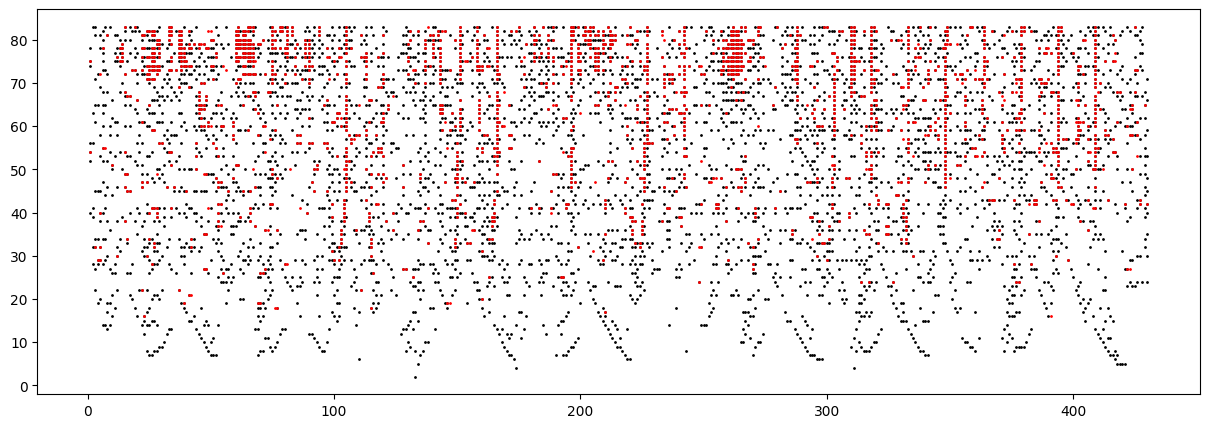

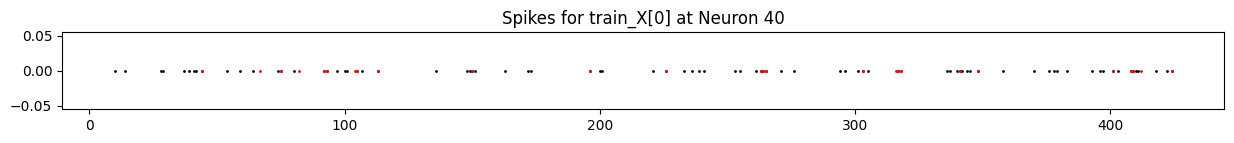

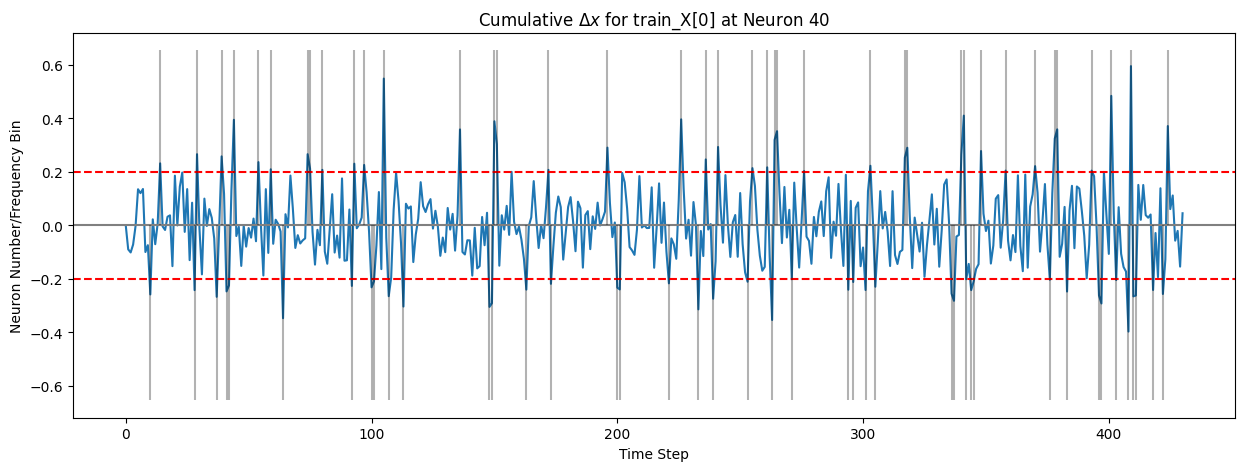

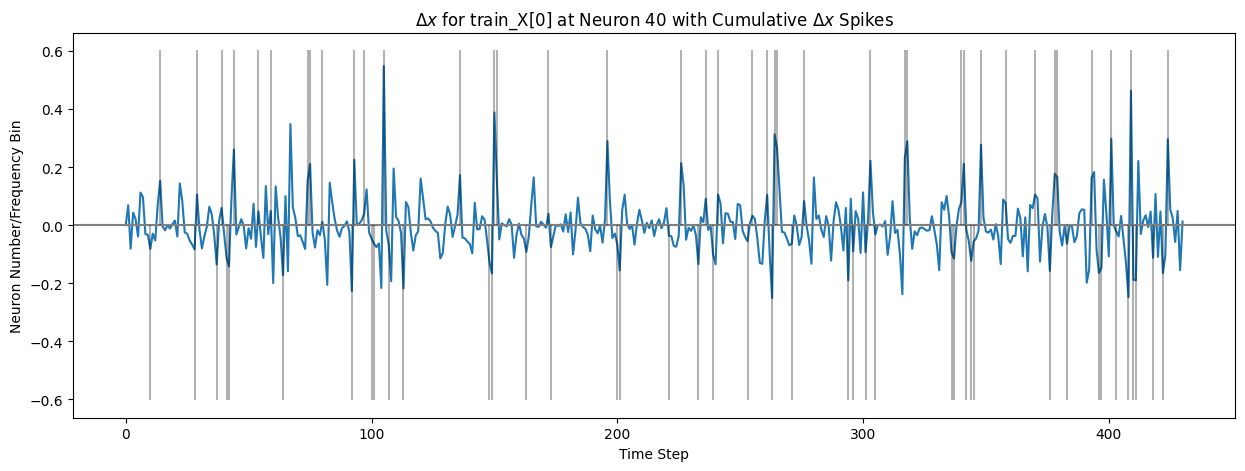

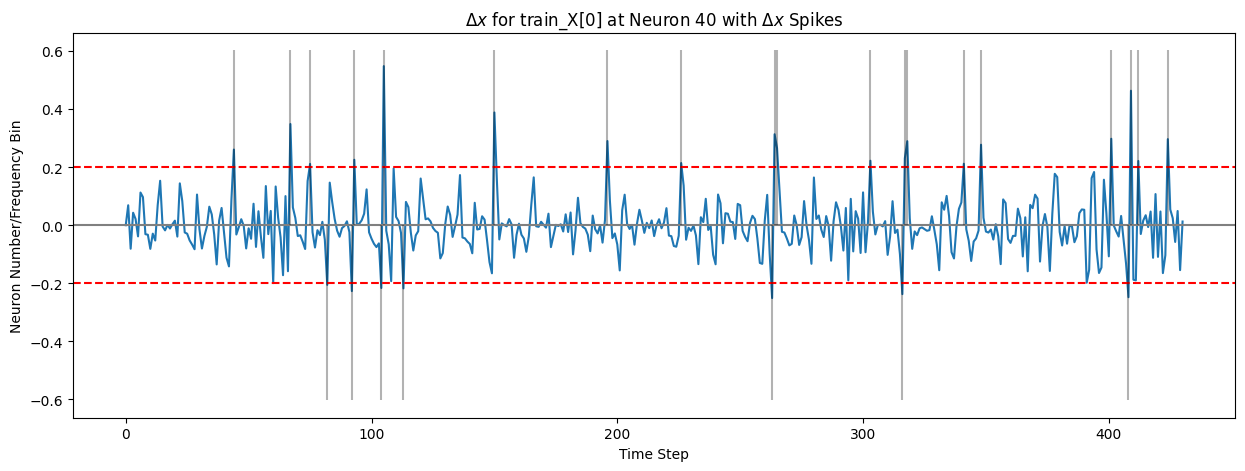

In [205]:
from matplotlib import pyplot as plt
import snntorch.spikeplot as splt

train: TensorDataset = cqt_train
test: TensorDataset = cqt_test

train_X, train_Y = train.tensors
test_X, test_Y = test.tensors

#spikes, cumsum, delta_data = delta(train_X, threshold=0.2, cumulative=True, return_intermediate_steps=True)
#nocum_spikes = delta(train_X, threshold=0.2, off_spike=True)

fig = plt.figure(facecolor="w", figsize=(15, 5))
ax = fig.add_subplot(111)
splt.raster(spikes[0], ax, s=1, c="black")
splt.raster(nocum_spikes[0], ax, s=1, c="red")
plt.show()

fig = plt.figure(facecolor="w", figsize=(15, 1))
ax = fig.add_subplot(111)
splt.raster(spikes[0,:,50], ax, s=1, c="black")
splt.raster(nocum_spikes[0,:,50], ax, s=1, c="red")
plt.title("Spikes for train_X[0] at Neuron 40")
plt.show()

fig = plt.figure(facecolor="w", figsize=(15, 5))
ax = fig.add_subplot(111)
graph_frequency(cumsum[0,:,50], fig, ax, spikes[0,:,50], threshold=0.2, plot_labels=(r"Cumulative $\Delta x$", "Spikes"), plot_title=r'Cumulative $\Delta x$ for train_X[0] at Neuron 40')

fig = plt.figure(facecolor="w", figsize=(15, 5))
ax = fig.add_subplot(111)
graph_frequency(delta_data[0,:,50], fig, ax, spikes[0,:,50], plot_labels=(r"$\Delta x$", "Spikes"), plot_title=r'$\Delta x$ for train_X[0] at Neuron 40 with Cumulative $\Delta x$ Spikes')

fig = plt.figure(facecolor="w", figsize=(15, 5))
ax = fig.add_subplot(111)
graph_frequency(delta_data[0,:,50], fig, ax, nocum_spikes[0,:,50], threshold=0.2, plot_labels=(r"$\Delta x$", "Spikes"), plot_title=r'$\Delta x$ for train_X[0] at Neuron 40 with $\Delta x$ Spikes')



In [43]:
train: TensorDataset = cqt_train
test: TensorDataset = cqt_test

delta_direct_train = delta(train, threshold=False)
delta_direct_test = delta(test, threshold=False)

torch.save(delta_direct_train,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_temporal/cqt_train.pth")
torch.save(delta_direct_test,f"{FILEPATH}/encodings/{SAVE_DIR}/direct_temporal/cqt_test.pth")

NameError: name 'cqt_train' is not defined

In [ ]:
delta_direct_train = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_temporal/cqt_train.pth")
delta_direct_test = torch.load(f"{FILEPATH}/encodings/{SAVE_DIR}/direct_temporal/cqt_test.pth")

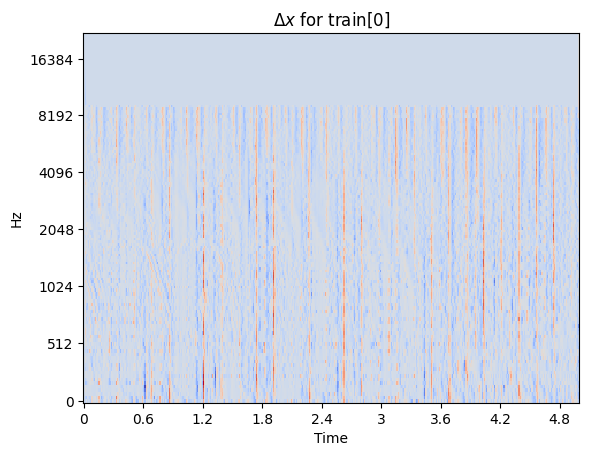

electronica
torch.Size([431, 128])


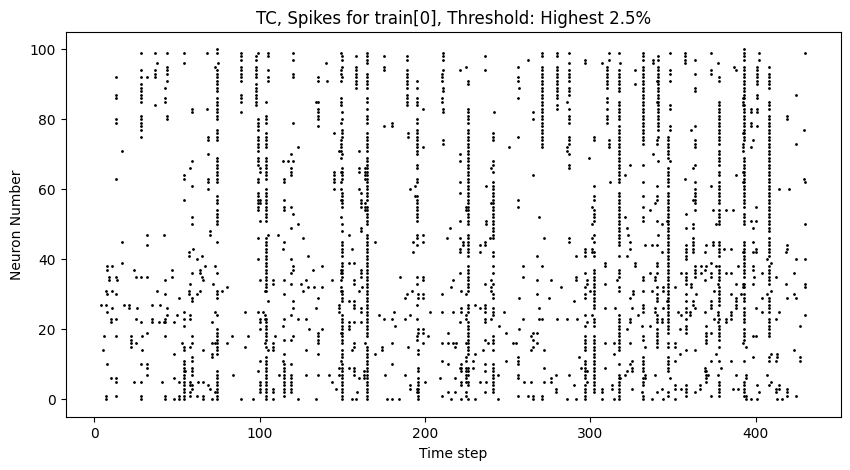

In [183]:
from matplotlib import pyplot as plt
import snntorch.spikeplot as splt
import librosa

# For ease set training and testing set to be specific variable
# Ease of changing spectrogram type
train: TensorDataset = mel_train
test: TensorDataset = mel_test

train_X, train_Y = train.tensors
test_X, test_Y = test.tensors

train_X= delta(train_X, threshold=None, padding=True)

librosa.display.specshow((train_X[0]).numpy().T, sr=44100, x_axis='time', y_axis='mel')
plt.title(r"$\Delta x$ for train[0]")
plt.show()

percent = 2.5
DELTA_THRESHOLD = np.percentile((train_X[:,1:] - train_X[:,:-1]).abs(), 100 - percent)
print(label_mappings[int(train_Y[0])])

# Generate the spikes based on the training and testing data, with a threshold 
train_X= delta(train_X, threshold=DELTA_THRESHOLD, padding=True)


# train, test = TensorDataset(train_X, train_Y), TensorDataset(test_X, test_Y)
print(train_X[0].shape)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(train_X[0], ax, s=1, c="black")

plt.title(f"TC, Spikes for train[0], Threshold: Highest {percent}%")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

## 1. Multi-Layer Perceptrons

### Time based input, Leaky MLP-SNN, 1 Hidden Layer (FNN), Direct Input (Delta Modulation)

In [100]:
# For ease set training and testing set to be specific variable
# Ease of changing spectrogram type
train, test = mel_train, mel_test

# Set input, step, and hidden node size based on a single training sample (assuming they're uniform and normalised)
sample, _ = train[0]                # Sample in form Time x Frequency Bins

num_inputs = sample.shape[1]        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_steps = sample.shape[0]         # Number of samples per spectrogram (or spectrogram sample rate * time of audio; x-axis)
num_hidden = num_inputs // 2        # Ideally half the number of inputs (originally 1000)
num_hidden_layers = 1               # 2 hidden layers with num_hidden nodes each
num_outputs = len(label_mappings)                      # Either Music or Non-Music

In [101]:
# Set decay rate and threshold:
# Arbitrary threshold, decay rate set close to 1 for reasonable accuracy -- given delta_t << tau in: beta = (1 - delta_t/tau)
beta = 0.95
threshold = 1

class Net(nn.Module):
    # Initialise network with 2 forward connections (linear connections) and 2 leaky integrated fire layers (hidden and output)
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    # Define a forward pass assuming x is normalised data (i.e. all values in [0,1])
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        # Step through the time sets within the data -- get current from data at a given time, forward it to lif
        # Use the lif spikes to generate a current from spikes, feed this through a second (output) lif
        for step in range(num_steps):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [102]:
def train_mlp(train_set, test_set, num_epochs, batch_size):

    # Helper output functions
    def print_batch_accuracy(data, targets, train=False):
        _, _, output, _ = net(data)
        _, idx = output.sum(dim=0).max(1)
        acc = np.mean((targets == idx).detach().cpu().numpy())

        if train:
            print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        else:
            print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
        print(f"Epoch {epoch}, Iteration {iter_counter}")
        print(f"Train Set Loss: {loss_hist[counter]:.2f}")
        print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
        print_batch_accuracy(data, targets, train=True)
        print_batch_accuracy(test_data, test_targets, train=False)
        print("\n")


    # Initialise network. Set to cuda where available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = Net().to(device)

    # Make train and test dataloaders based on batch_size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Initialise loss (CE Loss) and Adam optimiser -- learning rate is a hyperparameter
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

    counter = 0
    loss_hist = []
    test_loss_hist = []

    # Train for num_epochs
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)

        # Loop through batches -- separate out data and targets in each batch [batch_size x times x frequencies]
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # Forward Pass in train mode
            net.train()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data)

            # Sum loss over time (batch membrane2 records for each time step against batch targets)
            loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                loss_val += loss(mem2_rec[step], targets)

            # Weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Loss history storage
            loss_hist.append(loss_val.item())

            # Test set (for loss history in current form)
            # Performance boost if only evaluated when counter / 50 
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Forward Pass in test ode
                test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data)

                # Sum loss over time for test set
                test_loss = torch.zeros((1), dtype=torch.float32, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem2[step], test_targets)
                test_loss_hist.append(test_loss.item())

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
                counter += 1
                iter_counter +=1

    return net, loss_hist, test_loss_hist

In [103]:
def test_mlp(net, train_set, test_set):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Get all train and test data
    data, targets = train_set.tensors[0], train_set.tensors[1]
    test_data, test_targets = test_set.tensors[0], test_set.tensors[1]

    # Find overall train accuracy
    # Check max spikes in output neurons, compare against targets
    _, _, output, _ = net(data.to(device))
    _, idx = output.sum(dim=0).max(1)
    train_acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
    print(train_acc)

    # Find overall test accuracy
    _, _, output, _ = net(test_data.to(device))
    _, idx = output.sum(dim=0).max(1)
    test_acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
    print(test_acc)

    return train_acc, test_acc

In [104]:
train: TensorDataset = mel_train
test: TensorDataset = mel_test

train_X, train_Y = train.tensors
test_X, test_Y = test.tensors

num_epochs = 25
batch_size = 20

# Generate the spikes based on the training and testing data, with a threshold 
train_X_delta, test_X_delta = delta(train_X, threshold=None, padding=True), delta(test_X, threshold=None, padding=True)

train_delta, test_delta = TensorDataset(train_X_delta, train_Y), TensorDataset(test_X_delta, test_Y)

print(f"Training MLP (Delta x):")

net, _, _ = train_mlp(train_delta, test_delta, num_epochs, batch_size)

print(f"Testing MLP (Delta x):")

train_acc, test_acc = test_mlp(net, train_delta, test_delta)



Training MLP (Delta x):
Epoch 0, Iteration 0
Train Set Loss: 1025.64
Test Set Loss: 1114.32
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 30.00%


Epoch 2, Iteration 12
Train Set Loss: 1007.01
Test Set Loss: 1173.87
Train set accuracy for a single minibatch: 10.00%
Test set accuracy for a single minibatch: 5.00%


Epoch 5, Iteration 5
Train Set Loss: 1017.93
Test Set Loss: 918.39
Train set accuracy for a single minibatch: 10.00%
Test set accuracy for a single minibatch: 15.00%


Epoch 7, Iteration 17
Train Set Loss: 1011.79
Test Set Loss: 968.48
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 10, Iteration 10
Train Set Loss: 972.30
Test Set Loss: 1057.33
Train set accuracy for a single minibatch: 10.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 13, Iteration 3
Train Set Loss: 904.93
Test Set Loss: 845.19
Train set accuracy for a single minibatch: 25.00%
Test set accur

### Time based input, Leaky MLP-SNN, 1 Hidden Layer (FNN), On-Spikes Only

In [139]:
# For ease set training and testing set to be specific variable
# Ease of changing spectrogram type
train, test = mfcc_train, mfcc_test

# Set input, step, and hidden node size based on a single training sample (assuming they're uniform and normalised)
sample, _ = train[0]                # Sample in form Time x Frequency Bins

num_inputs = sample.shape[1]        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_steps = sample.shape[0]         # Number of samples per spectrogram (or spectrogram sample rate * time of audio; x-axis)
num_hidden = num_inputs // 2        # Ideally half the number of inputs (originally 1000)
num_hidden_layers = 1               # 2 hidden layers with num_hidden nodes each
num_outputs = len(label_mappings)                      # Either Music or Non-Music

In [140]:
# Set decay rate and threshold:
# Arbitrary threshold, decay rate set close to 1 for reasonable accuracy -- given delta_t << tau in: beta = (1 - delta_t/tau)
beta = 0.95
threshold = 0.75

class Net(nn.Module):
    # Initialise network with 2 forward connections (linear connections) and 2 leaky integrated fire layers (hidden and output)
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    # Define a forward pass assuming x is normalised data (i.e. all values in [0,1])
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        # Step through the time sets within the data -- get current from data at a given time, forward it to lif
        # Use the lif spikes to generate a current from spikes, feed this through a second (output) lif
        for step in range(num_steps):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [141]:
def train_mlp(train_set, test_set, num_epochs, batch_size):

    # Helper output functions
    def print_batch_accuracy(data, targets, train=False):
        _, _, output, _ = net(data)
        _, idx = output.sum(dim=0).max(1)
        acc = np.mean((targets == idx).detach().cpu().numpy())

        if train:
            print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        else:
            print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
        print(f"Epoch {epoch}, Iteration {iter_counter}")
        print(f"Train Set Loss: {loss_hist[counter]:.2f}")
        print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
        print_batch_accuracy(data, targets, train=True)
        print_batch_accuracy(test_data, test_targets, train=False)
        print("\n")


    # Initialise network. Set to cuda where available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = Net().to(device)

    # Make train and test dataloaders based on batch_size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Initialise loss (CE Loss) and Adam optimiser -- learning rate is a hyperparameter
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

    counter = 0
    loss_hist = []
    test_loss_hist = []

    # Train for num_epochs
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)

        # Loop through batches -- separate out data and targets in each batch [batch_size x times x frequencies]
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # Forward Pass in train mode
            net.train()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data)

            # Sum loss over time (batch membrane2 records for each time step against batch targets)
            loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                loss_val += loss(mem2_rec[step], targets)

            # Weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Loss history storage
            loss_hist.append(loss_val.item())

            # Test set (for loss history in current form)
            # Performance boost if only evaluated when counter / 50 
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Forward Pass in test ode
                test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data)

                # Sum loss over time for test set
                test_loss = torch.zeros((1), dtype=torch.float32, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem2[step], test_targets)
                test_loss_hist.append(test_loss.item())

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
                counter += 1
                iter_counter +=1

    return net, loss_hist, test_loss_hist

In [142]:
def test_mlp(net, train_set, test_set):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Get all train and test data
    data, targets = train_set.tensors[0], train_set.tensors[1]
    test_data, test_targets = test_set.tensors[0], test_set.tensors[1]

    # Find overall train accuracy
    # Check max spikes in output neurons, compare against targets
    _, _, output, _ = net(data.to(device))
    _, idx = output.sum(dim=0).max(1)
    train_acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
    print(train_acc)

    # Find overall test accuracy
    _, _, output, _ = net(test_data.to(device))
    _, idx = output.sum(dim=0).max(1)
    test_acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
    print(test_acc)

    return train_acc, test_acc

In [143]:
def calculate_threshold(dataset, top_percentile):
    if isinstance(dataset, TensorDataset): dataset_X, _ = dataset.tensors
    else: dataset_X = dataset
    return np.percentile((dataset_X[:,1:] - dataset_X[:,:-1]).abs(), 100 - top_percentile)

In [144]:
train: TensorDataset = mfcc_train
test: TensorDataset = mfcc_test

train_X, train_Y = train.tensors
test_X, test_Y = test.tensors

num_epochs = 25
batch_size = 20

train_accuracies = dict()
test_accuracies = dict()

percentages = [0.5, 1, 2, 4, 8, 12, 15, 20, 30, 50]

for percent in percentages:
    DELTA_THRESHOLD = calculate_threshold(train_X, percent)

    # Generate the spikes based on the training and testing data, with a threshold 
    train_X_spiked, test_X_spiked = delta(train_X, threshold=DELTA_THRESHOLD, padding=True), delta(test_X, threshold=DELTA_THRESHOLD, padding=True)

    train_spiked, test_spiked = TensorDataset(train_X_spiked, train_Y), TensorDataset(test_X_spiked, test_Y)

    print(f"Training MLP with Threshold: {DELTA_THRESHOLD} ({percent}%)")

    net, _, _ = train_mlp(train_spiked, test_spiked, num_epochs, batch_size)

    print(f"Testing MLP with Threshold: {DELTA_THRESHOLD} ({percent}%)")

    train_acc, test_acc = test_mlp(net, train_spiked, test_spiked)

    train_accuracies[percent], test_accuracies[percent] = train_acc, test_acc



Training MLP with Threshold: 0.05142909035086604 (0.5%)


Epoch 0, Iteration 0
Train Set Loss: 1724.10
Test Set Loss: 2216.28
Train set accuracy for a single minibatch: 30.00%
Test set accuracy for a single minibatch: 15.00%


Epoch 2, Iteration 12
Train Set Loss: 1947.13
Test Set Loss: 1562.95
Train set accuracy for a single minibatch: 10.00%
Test set accuracy for a single minibatch: 10.00%


Epoch 5, Iteration 5
Train Set Loss: 1578.43
Test Set Loss: 1287.09
Train set accuracy for a single minibatch: 20.00%
Test set accuracy for a single minibatch: 40.00%


Epoch 7, Iteration 17
Train Set Loss: 1056.98
Test Set Loss: 1228.05
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 20.00%


Epoch 10, Iteration 10
Train Set Loss: 1154.02
Test Set Loss: 1451.47
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 20.00%


Epoch 13, Iteration 3
Train Set Loss: 1189.81
Test Set Loss: 1203.37
Train set accuracy for a single minibatch: 15.00%
Test set accuracy for a single m

### Time based input, Leaky MLP-SNN, 1 Hidden Layer (FNN), Off-Spikes

In [135]:
# For ease set training and testing set to be specific variable
# Ease of changing spectrogram type
train, test = mfcc_train, mfcc_test

# Set input, step, and hidden node size based on a single training sample (assuming they're uniform and normalised)
sample, _ = train[0]                # Sample in form Time x Frequency Bins

num_inputs = sample.shape[1]        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_steps = sample.shape[0]         # Number of samples per spectrogram (or spectrogram sample rate * time of audio; x-axis)
num_hidden = num_inputs // 2        # Ideally half the number of inputs (originally 1000)
num_hidden_layers = 1               # 2 hidden layers with num_hidden nodes each
num_outputs = len(label_mappings)                      # Either Music or Non-Music

20 431 10


In [130]:
# Set decay rate and threshold:
# Arbitrary threshold, decay rate set close to 1 for reasonable accuracy -- given delta_t << tau in: beta = (1 - delta_t/tau)
beta = 0.95
threshold = 0.75

class Net(nn.Module):
    # Initialise network with 2 forward connections (linear connections) and 2 leaky integrated fire layers (hidden and output)
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    # Define a forward pass assuming x is normalised data (i.e. all values in [0,1])
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        # Step through the time sets within the data -- get current from data at a given time, forward it to lif
        # Use the lif spikes to generate a current from spikes, feed this through a second (output) lif
        for step in range(num_steps):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [131]:
def train_mlp(train_set, test_set, num_epochs, batch_size):

    # Helper output functions
    def print_batch_accuracy(data, targets, train=False):
        _, _, output, _ = net(data)
        _, idx = output.sum(dim=0).max(1)
        acc = np.mean((targets == idx).detach().cpu().numpy())

        if train:
            print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        else:
            print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
        print(f"Epoch {epoch}, Iteration {iter_counter}")
        print(f"Train Set Loss: {loss_hist[counter]:.2f}")
        print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
        print_batch_accuracy(data, targets, train=True)
        print_batch_accuracy(test_data, test_targets, train=False)
        print("\n")


    # Initialise network. Set to cuda where available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = Net().to(device)

    # Make train and test dataloaders based on batch_size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Initialise loss (CE Loss) and Adam optimiser -- learning rate is a hyperparameter
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

    counter = 0
    loss_hist = []
    test_loss_hist = []

    # Train for num_epochs
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)

        # Loop through batches -- separate out data and targets in each batch [batch_size x times x frequencies]
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # Forward Pass in train mode
            net.train()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data)

            # Sum loss over time (batch membrane2 records for each time step against batch targets)
            loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                loss_val += loss(mem2_rec[step], targets)

            # Weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Loss history storage
            loss_hist.append(loss_val.item())

            # Test set (for loss history in current form)
            # Performance boost if only evaluated when counter / 50 
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Forward Pass in test ode
                test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data)

                # Sum loss over time for test set
                test_loss = torch.zeros((1), dtype=torch.float32, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem2[step], test_targets)
                test_loss_hist.append(test_loss.item())

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
                counter += 1
                iter_counter +=1

    return net, loss_hist, test_loss_hist

In [132]:
def test_mlp(net, train_set, test_set):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Get all train and test data
    data, targets = train_set.tensors[0], train_set.tensors[1]
    test_data, test_targets = test_set.tensors[0], test_set.tensors[1]

    # Find overall train accuracy
    # Check max spikes in output neurons, compare against targets
    _, _, output, _ = net(data.to(device))
    _, idx = output.sum(dim=0).max(1)
    train_acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
    print(train_acc)

    # Find overall test accuracy
    _, _, output, _ = net(test_data.to(device))
    _, idx = output.sum(dim=0).max(1)
    test_acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
    print(test_acc)

    return train_acc, test_acc

In [133]:
def calculate_threshold(dataset, top_percentile):
    if isinstance(dataset, TensorDataset): dataset_X, _ = dataset.tensors
    else: dataset_X = dataset
    return np.percentile((dataset_X[:,1:] - dataset_X[:,:-1]).abs(), 100 - top_percentile)

In [138]:
train: TensorDataset = mfcc_train
test: TensorDataset = mfcc_test

train_X, train_Y = train.tensors
test_X, test_Y = test.tensors

num_epochs = 25
batch_size = 20

OFFtrain_accuracies = dict()
OFFtest_accuracies = dict()

percentages = [0.5, 1, 2, 4, 8, 12, 15, 20, 30, 50]

for percent in percentages:
    DELTA_THRESHOLD = calculate_threshold(train_X, percent)

    # Generate the spikes based on the training and testing data, with a threshold 
    train_X_spiked, test_X_spiked = delta(train_X, threshold=DELTA_THRESHOLD, padding=True, off_spike=True), delta(test_X, threshold=DELTA_THRESHOLD, padding=True, off_spike=True)

    train_spiked, test_spiked = TensorDataset(train_X_spiked, train_Y), TensorDataset(test_X_spiked, test_Y)

    print(f"Training MLP with Threshold: {DELTA_THRESHOLD} ({percent}%)")

    net, _, _ = train_mlp(train_spiked, test_spiked, num_epochs, batch_size)

    print(f"Testing MLP with Threshold: {DELTA_THRESHOLD} ({percent}%)")

    train_acc, test_acc = test_mlp(net, train_spiked, test_spiked)

    OFFtrain_accuracies[percent], OFFtest_accuracies[percent] = train_acc, test_acc



Training MLP with Threshold: 0.05142909035086604 (0.5%)
Epoch 0, Iteration 0
Train Set Loss: 1904.17
Test Set Loss: 2028.81
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 2, Iteration 12
Train Set Loss: 1490.50
Test Set Loss: 2041.36
Train set accuracy for a single minibatch: 5.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 5, Iteration 5
Train Set Loss: 1344.67
Test Set Loss: 1621.54
Train set accuracy for a single minibatch: 30.00%
Test set accuracy for a single minibatch: 20.00%


Epoch 7, Iteration 17
Train Set Loss: 1322.78
Test Set Loss: 1654.11
Train set accuracy for a single minibatch: 20.00%
Test set accuracy for a single minibatch: 20.00%


Epoch 10, Iteration 10
Train Set Loss: 1228.87
Test Set Loss: 1197.53
Train set accuracy for a single minibatch: 10.00%
Test set accuracy for a single minibatch: 20.00%


Epoch 13, Iteration 3
Train Set Loss: 1163.85
Test Set Loss: 1114.85
Train set accuracy for a singl

### Time based input, Leaky MLP-SNN, 1 Hidden Layer (FNN), Accumulative On-Spikes Only

In [84]:
# For ease set training and testing set to be specific variable
# Ease of changing spectrogram type
train, test = mel_train, mel_test

# Set input, step, and hidden node size based on a single training sample (assuming they're uniform and normalised)
sample, _ = train[0]                # Sample in form Time x Frequency Bins

num_inputs = sample.shape[1]        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_steps = sample.shape[0]         # Number of samples per spectrogram (or spectrogram sample rate * time of audio; x-axis)
num_hidden = num_inputs // 2        # Ideally half the number of inputs (originally 1000)
num_hidden_layers = 1               # 2 hidden layers with num_hidden nodes each
num_outputs = len(label_mappings)                      # Either Music or Non-Music

In [85]:
# Set decay rate and threshold:
# Arbitrary threshold, decay rate set close to 1 for reasonable accuracy -- given delta_t << tau in: beta = (1 - delta_t/tau)
beta = 0.95
threshold = 0.75

class Net(nn.Module):
    # Initialise network with 2 forward connections (linear connections) and 2 leaky integrated fire layers (hidden and output)
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    # Define a forward pass assuming x is normalised data (i.e. all values in [0,1])
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        # Step through the time sets within the data -- get current from data at a given time, forward it to lif
        # Use the lif spikes to generate a current from spikes, feed this through a second (output) lif
        for step in range(num_steps):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [86]:
def train_mlp(train_set, test_set, num_epochs, batch_size):

    # Helper output functions
    def print_batch_accuracy(data, targets, train=False):
        _, _, output, _ = net(data)
        _, idx = output.sum(dim=0).max(1)
        acc = np.mean((targets == idx).detach().cpu().numpy())

        if train:
            print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        else:
            print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
        print(f"Epoch {epoch}, Iteration {iter_counter}")
        print(f"Train Set Loss: {loss_hist[counter]:.2f}")
        print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
        print_batch_accuracy(data, targets, train=True)
        print_batch_accuracy(test_data, test_targets, train=False)
        print("\n")


    # Initialise network. Set to cuda where available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = Net().to(device)

    # Make train and test dataloaders based on batch_size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Initialise loss (CE Loss) and Adam optimiser -- learning rate is a hyperparameter
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

    counter = 0
    loss_hist = []
    test_loss_hist = []

    # Train for num_epochs
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)

        # Loop through batches -- separate out data and targets in each batch [batch_size x times x frequencies]
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # Forward Pass in train mode
            net.train()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data)

            # Sum loss over time (batch membrane2 records for each time step against batch targets)
            loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                loss_val += loss(mem2_rec[step], targets)

            # Weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Loss history storage
            loss_hist.append(loss_val.item())

            # Test set (for loss history in current form)
            # Performance boost if only evaluated when counter / 50 
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Forward Pass in test ode
                test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data)

                # Sum loss over time for test set
                test_loss = torch.zeros((1), dtype=torch.float32, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem2[step], test_targets)
                test_loss_hist.append(test_loss.item())

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
                counter += 1
                iter_counter +=1

    return net, loss_hist, test_loss_hist

In [87]:
def test_mlp(net, train_set, test_set):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Get all train and test data
    data, targets = train_set.tensors[0], train_set.tensors[1]
    test_data, test_targets = test_set.tensors[0], test_set.tensors[1]

    # Find overall train accuracy
    # Check max spikes in output neurons, compare against targets
    _, _, output, _ = net(data.to(device))
    _, idx = output.sum(dim=0).max(1)
    train_acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
    print(train_acc)

    # Find overall test accuracy
    _, _, output, _ = net(test_data.to(device))
    _, idx = output.sum(dim=0).max(1)
    test_acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
    print(test_acc)

    return train_acc, test_acc

In [88]:
train: TensorDataset = mel_train
test: TensorDataset = mel_test

num_epochs = 25
batch_size = 20

train_accuracies = dict()
test_accuracies = dict()

thresholds = np.logspace(-2, 1, 10)

for threshold in thresholds:
    # Generate the spikes based on the training and testing data, with a threshold 
    train_spiked, test_spiked = delta(train, threshold=threshold, padding=True, cumulative=True), delta(test, threshold=threshold, padding=True, cumulative=True)

    print(f"Training MLP with Threshold: {threshold}")

    net, _, _ = train_mlp(train_spiked, test_spiked, num_epochs, batch_size)

    print(f"Testing MLP with Threshold: {threshold}")

    train_acc, test_acc = test_mlp(net, train_spiked, test_spiked)

    train_accuracies[threshold], test_accuracies[threshold] = train_acc, test_acc

print(train_accuracies)
print(test_accuracies)



Training MLP with Threshold: 0.01
Epoch 0, Iteration 0
Train Set Loss: 1147.76
Test Set Loss: 1144.12
Train set accuracy for a single minibatch: 15.00%
Test set accuracy for a single minibatch: 35.00%


Epoch 2, Iteration 12
Train Set Loss: 1097.60
Test Set Loss: 1000.29
Train set accuracy for a single minibatch: 20.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 5, Iteration 5
Train Set Loss: 818.39
Test Set Loss: 892.10
Train set accuracy for a single minibatch: 40.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 7, Iteration 17
Train Set Loss: 887.54
Test Set Loss: 1060.28
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 10, Iteration 10
Train Set Loss: 860.79
Test Set Loss: 1113.91
Train set accuracy for a single minibatch: 40.00%
Test set accuracy for a single minibatch: 20.00%


Epoch 13, Iteration 3
Train Set Loss: 985.49
Test Set Loss: 965.05
Train set accuracy for a single minibatch: 35.00%
Test

### Time based input, Leaky MLP-SNN, 1 Hidden Layer (FNN), Accumulative Off-Spikes

In [77]:
# For ease set training and testing set to be specific variable
# Ease of changing spectrogram type
train, test = mel_train, mel_test

# Set input, step, and hidden node size based on a single training sample (assuming they're uniform and normalised)
sample, _ = train[0]                # Sample in form Time x Frequency Bins

num_inputs = sample.shape[1]        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_steps = sample.shape[0]         # Number of samples per spectrogram (or spectrogram sample rate * time of audio; x-axis)
num_hidden = num_inputs // 2        # Ideally half the number of inputs (originally 1000)
num_hidden_layers = 1               # 2 hidden layers with num_hidden nodes each
num_outputs = len(label_mappings)                      # Either Music or Non-Music

In [79]:
# Set decay rate and threshold:
# Arbitrary threshold, decay rate set close to 1 for reasonable accuracy -- given delta_t << tau in: beta = (1 - delta_t/tau)
beta = 0.95
threshold = 1

class Net(nn.Module):
    # Initialise network with 2 forward connections (linear connections) and 2 leaky integrated fire layers (hidden and output)
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    # Define a forward pass assuming x is normalised data (i.e. all values in [0,1])
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        # Step through the time sets within the data -- get current from data at a given time, forward it to lif
        # Use the lif spikes to generate a current from spikes, feed this through a second (output) lif
        for step in range(num_steps):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [80]:
def train_mlp(train_set, test_set, num_epochs, batch_size):

    # Helper output functions
    def print_batch_accuracy(data, targets, train=False):
        _, _, output, _ = net(data)
        _, idx = output.sum(dim=0).max(1)
        acc = np.mean((targets == idx).detach().cpu().numpy())

        if train:
            print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        else:
            print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
        print(f"Epoch {epoch}, Iteration {iter_counter}")
        print(f"Train Set Loss: {loss_hist[counter]:.2f}")
        print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
        print_batch_accuracy(data, targets, train=True)
        print_batch_accuracy(test_data, test_targets, train=False)
        print("\n")


    # Initialise network. Set to cuda where available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = Net().to(device)

    # Make train and test dataloaders based on batch_size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Initialise loss (CE Loss) and Adam optimiser -- learning rate is a hyperparameter
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

    counter = 0
    loss_hist = []
    test_loss_hist = []

    # Train for num_epochs
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)

        # Loop through batches -- separate out data and targets in each batch [batch_size x times x frequencies]
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # Forward Pass in train mode
            net.train()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data)

            # Sum loss over time (batch membrane2 records for each time step against batch targets)
            loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                loss_val += loss(mem2_rec[step], targets)

            # Weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Loss history storage
            loss_hist.append(loss_val.item())

            # Test set (for loss history in current form)
            # Performance boost if only evaluated when counter / 50 
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Forward Pass in test ode
                test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data)

                # Sum loss over time for test set
                test_loss = torch.zeros((1), dtype=torch.float32, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem2[step], test_targets)
                test_loss_hist.append(test_loss.item())

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
                counter += 1
                iter_counter +=1

    return net, loss_hist, test_loss_hist

In [81]:
def test_mlp(net, train_set, test_set):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Get all train and test data
    data, targets = train_set.tensors[0], train_set.tensors[1]
    test_data, test_targets = test_set.tensors[0], test_set.tensors[1]

    # Find overall train accuracy
    # Check max spikes in output neurons, compare against targets
    _, _, output, _ = net(data.to(device))
    _, idx = output.sum(dim=0).max(1)
    train_acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
    print(train_acc)

    # Find overall test accuracy
    _, _, output, _ = net(test_data.to(device))
    _, idx = output.sum(dim=0).max(1)
    test_acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
    print(test_acc)

    return train_acc, test_acc

In [83]:
train: TensorDataset = mel_train
test: TensorDataset = mel_test

num_epochs = 25
batch_size = 20

train_accuracies = dict()
test_accuracies = dict()

thresholds = np.logspace(-2, 1, 10)

for threshold in thresholds:
    # Generate the spikes based on the training and testing data, with a threshold 
    train_spiked, test_spiked = delta(train, threshold=threshold, padding=True, cumulative=True, off_spike=True), delta(test, threshold=threshold, padding=True, cumulative=True, off_spike=True)

    print(f"Training MLP with Threshold: {threshold}")

    net, _, _ = train_mlp(train_spiked, test_spiked, num_epochs, batch_size)

    print(f"Testing MLP with Threshold: {threshold}")

    train_acc, test_acc = test_mlp(net, train_spiked, test_spiked)

    train_accuracies[threshold], test_accuracies[threshold] = train_acc, test_acc

print(train_accuracies)
print(test_accuracies)



Training MLP with Threshold: 0.01
Epoch 0, Iteration 0
Train Set Loss: 1021.15
Test Set Loss: 1191.35
Train set accuracy for a single minibatch: 10.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 2, Iteration 12
Train Set Loss: 889.07
Test Set Loss: 1024.06
Train set accuracy for a single minibatch: 35.00%
Test set accuracy for a single minibatch: 35.00%


Epoch 5, Iteration 5
Train Set Loss: 980.81
Test Set Loss: 1022.20
Train set accuracy for a single minibatch: 20.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 7, Iteration 17
Train Set Loss: 926.30
Test Set Loss: 965.86
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 20.00%


Epoch 10, Iteration 10
Train Set Loss: 910.89
Test Set Loss: 970.62
Train set accuracy for a single minibatch: 20.00%
Test set accuracy for a single minibatch: 35.00%


Epoch 13, Iteration 3
Train Set Loss: 818.85
Test Set Loss: 970.34
Train set accuracy for a single minibatch: 40.00%
Test se

# Count Rate Encoding
0. Data Encoding
1. Multi-Layer Perceptrons


## 0. Data Encoding

In [205]:
train: TensorDataset = mel_train
test: TensorDataset = mel_test

train_X, train_Y = train.tensors
test_X, test_Y = test.tensors

def count(dataset: Union[TensorDataset, Tensor], max_spikes=10):
    if type(dataset) == TensorDataset:
        data, labels = dataset.tensors
    elif type(dataset) != Tensor:
        raise TypeError("Dataset should have been type Dataset (in form '(data, labels)') or Tensor (in form [n x t x f])")
    else:
        data = dataset

    # Calculate the number of spikes for each x
    num_spikes = ((data * max_spikes).round()).long().numpy()

    count_mapping = {x: ((1,)*x + (0,) * (max_spikes-x)) for x in range(max_spikes + 1)}

    num_spikes = np.transpose(num_spikes, (0, 2, 1))

    vectorized_mapping = np.vectorize(lambda num: count_mapping[num])
    spikes = vectorized_mapping(num_spikes)

    spikes = np.stack(spikes)
    spikes = np.transpose(spikes, (1, 2, 3, 0))
    spikes = spikes.reshape(num_spikes.shape + (-1,))

    spikes_shape = spikes.shape
    spikes = np.reshape(spikes, (spikes_shape[0], spikes_shape[1], -1))

    spikes = np.transpose(spikes, (0, 2, 1))

    if type(dataset) == TensorDataset:
        return TensorDataset(Tensor(spikes).to(torch.float32), labels)
    else:
        return Tensor(spikes)

In [ ]:
spikes = count(train_X)

fig = plt.figure(facecolor="w", figsize=(20, 5))
ax = fig.add_subplot(111)
splt.raster(spikes[0], ax, s=0.2, c="black")

plt.title(f"Count Encoding, Spikes for train[0], Scaled to Max 10 Spikes per timeframe")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

### Time based input, Leaky MLP-SNN, 1 Hidden Layer (FNN), 10-Spike Count Encoded

In [254]:
# For ease set training and testing set to be specific variable
# Ease of changing spectrogram type
train, test = count(mel_train), count(mel_test)

# Set input, step, and hidden node size based on a single training sample (assuming they're uniform and normalised)
sample, _ = train[0]                # Sample in form Time x Frequency Bins

num_inputs = sample.shape[1]        # Depends on the input spectrogram (number of frequency bins; y-axis)
num_steps = sample.shape[0]         # Number of samples per spectrogram (or spectrogram sample rate * time of audio; x-axis)
num_hidden = num_inputs // 2        # Ideally half the number of inputs (originally 1000)
num_hidden_layers = 1               # 2 hidden layers with num_hidden nodes each
num_outputs = len(label_mappings)                      # Either Music or Non-Music

In [207]:
# Set decay rate and threshold:
# Arbitrary threshold, decay rate set close to 1 for reasonable accuracy -- given delta_t << tau in: beta = (1 - delta_t/tau)
beta = 0.95
threshold = 0.75

class Net(nn.Module):
    # Initialise network with 2 forward connections (linear connections) and 2 leaky integrated fire layers (hidden and output)
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    # Define a forward pass assuming x is normalised data (i.e. all values in [0,1])
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        # Step through the time sets within the data -- get current from data at a given time, forward it to lif
        # Use the lif spikes to generate a current from spikes, feed this through a second (output) lif
        for step in range(num_steps):
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [251]:
def train_mlp(train_set, test_set, num_epochs, batch_size):

    # Helper output functions
    def print_batch_accuracy(data, targets, train=False):
        _, _, output, _ = net(data)
        _, idx = output.sum(dim=0).max(1)
        acc = np.mean((targets == idx).detach().cpu().numpy())

        if train:
            print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        else:
            print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    def train_printer(epoch, iter_counter, data, targets, test_data, test_targets):
        print(f"Epoch {epoch}, Iteration {iter_counter}")
        print(f"Train Set Loss: {loss_hist[counter]:.2f}")
        print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
        print_batch_accuracy(data, targets, train=True)
        print_batch_accuracy(test_data, test_targets, train=False)
        print("\n")


    # Initialise network. Set to cuda where available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = Net().to(device)

    # Make train and test dataloaders based on batch_size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Initialise loss (CE Loss) and Adam optimiser -- learning rate is a hyperparameter
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

    counter = 0
    loss_hist = []
    test_loss_hist = []

    # Train for num_epochs
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)

        # Loop through batches -- separate out data and targets in each batch [batch_size x times x frequencies]
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # Forward Pass in train mode
            net.train()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data)
            
            # Sum loss over time (batch membrane2 records for each time step against batch targets)
            loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            loss_val += torch.stack([loss(mem2_rec[step], targets) for step in range(num_steps)]).to(device).sum()

            
            # Weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Loss history storage
            loss_hist.append(loss_val.item())

            # Test set (for loss history in current form)
            # Performance boost if only evaluated when counter / 50 
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Forward Pass in test ode
                test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data)

                # Sum loss over time for test set
                test_loss = torch.zeros((1), dtype=torch.float32, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem2[step], test_targets)
                test_loss_hist.append(test_loss.item())

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(epoch, iter_counter, data, targets, test_data, test_targets)
                counter += 1
                iter_counter +=1

    return net, loss_hist, test_loss_hist

In [252]:
def test_mlp(net, train_set, test_set):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Get all train and test data
    data, targets = train_set.tensors[0], train_set.tensors[1]
    test_data, test_targets = test_set.tensors[0], test_set.tensors[1]

    # Find overall train accuracy
    # Check max spikes in output neurons, compare against targets
    _, _, output, _ = net(data.to(device))
    _, idx = output.sum(dim=0).max(1)
    train_acc = np.mean((targets.to(device) == idx).detach().cpu().numpy())
    print(train_acc)

    # Find overall test accuracy
    _, _, output, _ = net(test_data.to(device))
    _, idx = output.sum(dim=0).max(1)
    test_acc = np.mean((test_targets.to(device) == idx).detach().cpu().numpy())
    print(test_acc)

    return train_acc, test_acc

In [255]:
num_epochs = 25
batch_size = 20

# Generate the spikes based on the training and testing data
train_count, test_count = train, test

print(f"Training MLP (Count x):")

net, _, _ = train_mlp(train_count, test_count, num_epochs, batch_size)

print(f"Testing MLP (Count x):")

train_acc, test_acc = test_mlp(net, train_count, test_count)



Training MLP (Count x):
Epoch 0, Iteration 0
Train Set Loss: 16713.20
Test Set Loss: 14643.83
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 2, Iteration 12
Train Set Loss: 10931.43
Test Set Loss: 11416.32
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 15.00%


Epoch 5, Iteration 5
Train Set Loss: 8843.13
Test Set Loss: 10734.19
Train set accuracy for a single minibatch: 35.00%
Test set accuracy for a single minibatch: 40.00%


Epoch 7, Iteration 17
Train Set Loss: 9316.34
Test Set Loss: 9512.27
Train set accuracy for a single minibatch: 15.00%
Test set accuracy for a single minibatch: 50.00%


Epoch 10, Iteration 10
Train Set Loss: 8802.90
Test Set Loss: 10192.71
Train set accuracy for a single minibatch: 35.00%
Test set accuracy for a single minibatch: 30.00%


Epoch 13, Iteration 3
Train Set Loss: 10614.96
Test Set Loss: 10800.89
Train set accuracy for a single minibatch: 25.00%
Te